# HS Hya
A changing-inclination binary! The previous prediction was that eclipses should [cease in 2022](https://ui.adsabs.harvard.edu/abs/2012A%26A...542L..23Z/abstract), which we'll be able to verify in TESS Sector 035 in [early 2021](https://heasarc.gsfc.nasa.gov/cgi-bin/tess/webtess/wtv.py?Entry=HS+Hya).


## Data Sources
(Note, a few of these didn't turn out interesting)
- [Gyldenkerne+1975](#Gyldenkerne+1975)
- [ASAS-SN](#ASAS-SN)
- [Hipparcos](#Hipparcos)
- [WISE](#WISE)
- [DASCH](#DASCH)
- [ASAS](#ASAS)
- [TESS](#TESS)

## Combined Plots
[Putting it all together](#Putting-it-all-together)


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.time import Time
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel, Trapezoid1DKernel
from scipy.optimize import curve_fit

# add for ref discussion
from astropy.timeseries import LombScargle, BoxLeastSquares

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [3]:
Per = 1.568024
E0 = 2441374.5954 # from Glydenkerne+1975, Eqn 1
BJD0_tess = 2457000.

def gaus(x, a, b, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) + b


## Gyldenkerne+1975

some exquisite narrow-band $ubvy$ photometry 

In [4]:
# helpfully digitized and made available here:
# http://caleb.eastern.edu/original_data_display.php?model_id=294
g75_file = 'data/Gyldenkerne1975.txt'

g75 = pd.read_table(g75_file, comment='#', sep=' ')
# g75

In [5]:
ubvy = (g75['d(u)'] + g75['d(b)'] + g75['d(v)'] + g75['d(y)']) / 4.

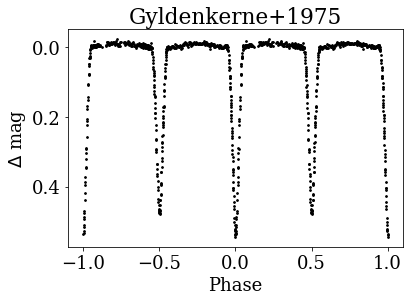

In [6]:
plt.scatter(((g75['dd'] + g75['dm'] + 2440000 - E0) % Per) / Per,  ubvy - np.nanmedian(ubvy), s=3, c='k')
plt.scatter(((g75['dd'] + g75['dm'] + 2440000 - E0) % Per) / Per - 1,  ubvy - np.nanmedian(ubvy), s=3, c='k')
plt.gca().invert_yaxis()
plt.xlabel('Phase')
plt.ylabel('$\Delta$ mag')
plt.title('Gyldenkerne+1975')
plt.savefig('Gyldenkerne1975.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

[ 5.33313251e-01 -5.54818011e-03  1.99121434e-05  1.89687420e-02]


Text(0.5, 1.0, 'Gyldenkerne+1975')

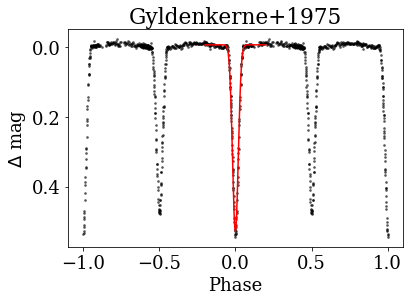

In [7]:
p0 = [0.5, 0., 0.01, 0.05]

xdata = np.hstack((((g75['dd'] + g75['dm'] + 2440000 - E0) % Per) / Per, 
                   ((g75['dd'] + g75['dm'] + 2440000 - E0) % Per) / Per - 1))
ydata = np.hstack((ubvy - np.nanmedian(ubvy), ubvy - np.nanmedian(ubvy)))

xr = np.where((xdata > -0.2) & (xdata < 0.2))[0]
xr = xr[np.argsort(xdata[xr])]
fit, cov = curve_fit(gaus, xdata[xr], ydata[xr], p0=p0)
print(fit)
fit_g75 = fit
err_g75 = np.sqrt(np.diag(cov))

plt.scatter(xdata, ydata, s=3, c='k', alpha=0.5)
plt.plot(xdata[xr], gaus(xdata[xr], *fit), c='r')
plt.gca().invert_yaxis()
plt.xlabel('Phase')
plt.ylabel('$\Delta$ mag')
plt.title('Gyldenkerne+1975')

## ASAS-SN

In [8]:
asassn = pd.read_csv('data/221524.csv')
# asassn

# this was the lightcurve that was pre-computed on their website

Text(0, 0.5, '$\\Delta$V (mag)')

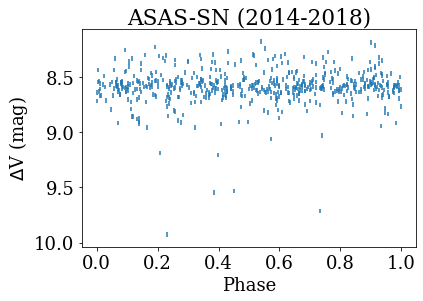

In [9]:
plt.errorbar(((asassn['hjd'].values - E0) % Per)/Per, asassn['mag'], 
             yerr=asassn['mag err'], linestyle='none')
plt.gca().invert_yaxis()
# plt.ylim(0.5, -0.2)
plt.title('ASAS-SN (2014-2018)')
plt.xlabel('Phase')
plt.ylabel('$\Delta$V (mag)')

In [10]:
# let's force their website to do photometry further back...
asassn2 = pd.read_csv('asassn2.csv')
# asassn2

In [11]:
# asassn2['HJD'][a2ok].values.min()

In [12]:
# a2ok = (asassn2['mag_err'] < 0.01) & (asassn2['Filter'] == 'g')

# plt.errorbar(((asassn2['HJD'][a2ok] - E0) % Per)/Per, asassn2['mag'][a2ok], 
#              yerr=asassn2['mag_err'][a2ok], linestyle='none')
# plt.gca().invert_yaxis()
# # plt.ylim(0.5, -0.2)
# # plt.title('ASAS-SN (2014-2018)')
# plt.xlabel('Phase')
# plt.ylabel('$\Delta$V (mag)')

## Hipparcos
So awesome

In [13]:
# Hipparcos light curve data (HIP 50966)
# http://cdsarc.u-strasbg.fr/viz-bin/nph-Plot/Vgraph/htm?I/239/50966&6069-1131-1
hip = pd.read_table('data/hipdata.txt', delimiter='|')
hip.columns

Index(['JD-2440000', ' Hpmag ', 's.e. ', 'Tflg'], dtype='object')

79


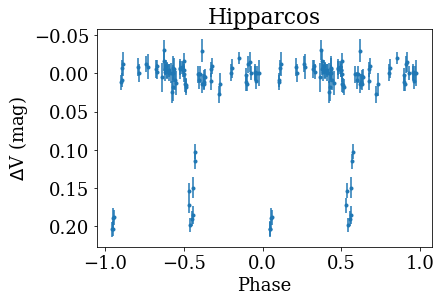

In [14]:
hok = hip['Tflg'] == 0
plt.errorbar(((hip['JD-2440000'][hok]+2440000 - E0) % Per) / Per, 
             hip[' Hpmag '][hok] - np.nanmedian(hip[' Hpmag '][hok]), yerr=hip['s.e. '][hok], 
             linestyle='None', marker='.', color='C0')
plt.errorbar(((hip['JD-2440000'][hok]+2440000 - E0) % Per) / Per - 1, 
             hip[' Hpmag '][hok] - np.nanmedian(hip[' Hpmag '][hok]), yerr=hip['s.e. '][hok], 
             linestyle='None', marker='.', color='C0')

plt.gca().invert_yaxis()
plt.xlabel('Phase')
plt.ylabel('$\Delta$V (mag)')
plt.title('Hipparcos')
print(sum(hok))

[ 0.20467054 -0.00107591  0.04853815  0.02181088]


Text(0.5, 1.0, 'Hipparcos')

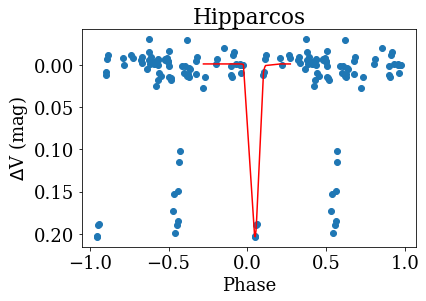

In [15]:
def gaus0(x, a, b, x0, sigma):
    # lock x0
    return a * np.exp(-(x - 0.025)**2 / (2 * sigma**2)) + b

p0 = [0.2, 0., 0.01, 0.05]

xdata = np.hstack((((hip['JD-2440000'][hok]+2440000 - E0) % Per) / Per, 
                   ((hip['JD-2440000'][hok]+2440000 - E0) % Per) / Per - 1))
ydata = np.hstack((hip[' Hpmag '][hok] - np.nanmedian(hip[' Hpmag '][hok]), 
                   hip[' Hpmag '][hok] - np.nanmedian(hip[' Hpmag '][hok])))

xr = np.where((xdata > -0.3) & (xdata < 0.3))[0]
xr = xr[np.argsort(xdata[xr])]
fit, cov = curve_fit(gaus, xdata[xr], ydata[xr], p0=p0)
print(fit)
fit_hip = fit
err_hip = np.sqrt(np.diag(cov))

plt.scatter(xdata, ydata, color='C0')
plt.plot(xdata[xr], gaus(xdata[xr], *fit), c='r')
plt.gca().invert_yaxis()
plt.xlabel('Phase')
plt.ylabel('$\Delta$V (mag)')
plt.title('Hipparcos')

## WISE
journey to the infrared!

In [16]:
# WISE

neowise = pd.read_csv('data/HS Hyaneowiser_p1bs_psd.csv')
wise4 = pd.read_csv('data/HS Hyaallsky_4band_p1bs_psd.csv')
wise2 = pd.read_csv('data/HS Hyaallsky_2band_p1bs_psd.csv')

wise_mjd = np.hstack( (wise4['mjd'], wise2['mjd'], neowise['mjd']))
wise_w1 =  np.hstack( (wise4['w1mpro'], wise2['w1mpro'], neowise['w1mpro']))
wise_w2 =  np.hstack( (wise4['w2mpro'], wise2['w2mpro'], neowise['w2mpro']))
wise_w1e =  np.hstack( (wise4['w1sigmpro'], wise2['w1sigmpro'], neowise['w1sigmpro']))
wise_w2e =  np.hstack( (wise4['w2sigmpro'], wise2['w2sigmpro'], neowise['w2sigmpro']))
wise_ph_qual = np.hstack( (wise4['ph_qual'].str[0:2], wise2['ph_qual'].str['0:2'], neowise['ph_qual'].str[0:2]))

(0.1, -0.1)

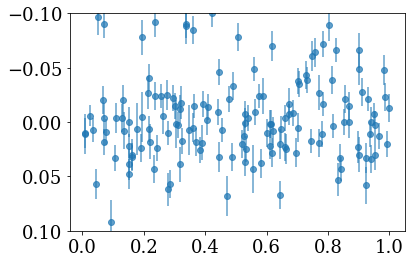

In [17]:
wgd = np.where((wise_ph_qual == 'AA'))[0]

# saturated in W1
# plt.errorbar(((wise_mjd[wgd] + 2400000.5 - E0) % Per) / Per, wise_w1[wgd], 
#              yerr= wise_w1e[wgd], linestyle='none', marker='o', alpha=0.7)

# JUST below saturation in W2... data kinda garbage?
plt.errorbar(((wise_mjd[wgd] + 2400000.5 - E0) % Per) / Per, wise_w2[wgd] - np.nanmedian(wise_w2[wgd]), 
             yerr= wise_w2e[wgd], linestyle='none', marker='o', alpha=0.7, c='C0')

# plt.scatter(((asas['HJD'][aok] + 2450000 - E0) % Per)/Per, asas['MAG_4'][aok] - np.nanmedian(asas['MAG_4'][aok]),
#             s=3, c='C5', alpha=0.4)

plt.gca().invert_yaxis()

plt.ylim(0.1, -0.1)


(0.11, -0.1)

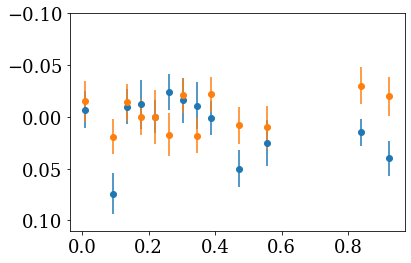

In [18]:
plt.errorbar(((wise4['mjd'].values + 2400000.5 - E0) % Per)/Per, wise4['w2mpro'] - np.nanmedian(wise4['w2mpro']), 
             yerr=wise4['w2sigmpro'], linestyle='none', marker='o')

plt.errorbar(((wise4['mjd'].values + 2400000.5 - E0) % Per)/Per, wise4['w3mpro'] - np.nanmedian(wise4['w3mpro']), 
             yerr=wise4['w3sigmpro'], linestyle='none', marker='o')

# plt.scatter(((asas['HJD'][aok] + 2450000 - E0) % Per)/Per, asas['MAG_4'][aok] - np.nanmedian(asas['MAG_4'][aok]),
#             s=3, c='C5', alpha=0.4)

plt.gca().invert_yaxis()
plt.ylim(0.11, -0.1)

## DASCH
if astronomy had a time machine...

HS Hya from [DASCH](http://dasch.rc.fas.harvard.edu/lightcurve_frame.php?coo=HS+Hya&nmin=1&box=5&source=atlas&frameformat=frame&submit=Search)

In [19]:
# DASCH archive!
dnames = ('Date', 'year', 'magcal_magdep', 'magcal_local_rms', 'limiting_mag_local', 
          'ra', 'dec', 'THETA_J2000', 'ELLIPTICITY', 'Plate', 'versionId', 'AFLAGS', 
          'BFLAGS', 'NUMBER', 'quality', 'timeAccuracy', 'AFLAGSBits', 'BFLAGSBits', 'qualitybits')

dasch = pd.read_table('data/plotshort_ATLAS2_551047062.txt', sep='|', names=dnames)
dasch.columns

Index(['Date', 'year', 'magcal_magdep', 'magcal_local_rms',
       'limiting_mag_local', 'ra', 'dec', 'THETA_J2000', 'ELLIPTICITY',
       'Plate', 'versionId', 'AFLAGS', 'BFLAGS', 'NUMBER', 'quality',
       'timeAccuracy', 'AFLAGSBits', 'BFLAGSBits', 'qualitybits'],
      dtype='object')

1390


(9.0, 7.5)

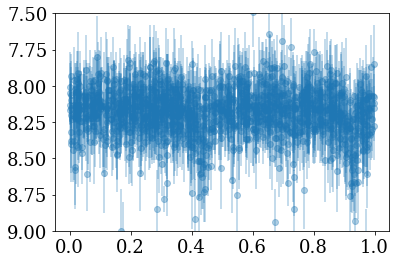

In [20]:
dbest = (dasch['magcal_local_rms'] < 0.3)
print(sum(dbest))
plt.errorbar(((dasch['Date'][dbest] - E0) % Per)/Per, dasch['magcal_magdep'][dbest], 
             yerr=dasch['magcal_local_rms'][dbest], 
             alpha=0.35, linestyle='none', marker='o')
plt.gca().invert_yaxis()
plt.ylim(9, 7.5)

In [21]:
dasch['year'][dbest].min()

1893.331782

In [22]:
dasch['year'][dbest].max()

1989.49403

(9.0, 7.5)

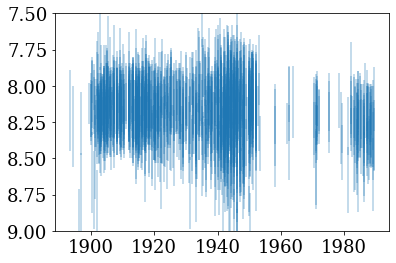

In [23]:
plt.errorbar(dasch['year'][dbest], dasch['magcal_magdep'][dbest], 
             yerr=dasch['magcal_local_rms'][dbest], 
             alpha=0.35, linestyle='none')
plt.gca().invert_yaxis()
plt.ylim(9, 7.5)

(9.0, 7.5)

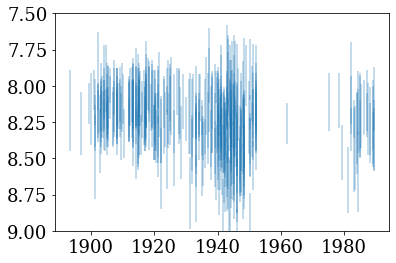

In [24]:
dphz = ((dasch['Date'][dbest] - E0) % Per)/Per
ecl = np.where(((dphz >= 0.4) & (dphz <= 0.55)) | 
               ((dphz >= 0.85) & (dphz <= 1)))[0]

plt.errorbar(dasch['year'].values[dbest][ecl], dasch['magcal_magdep'].values[dbest][ecl], 
             yerr=dasch['magcal_local_rms'].values[dbest][ecl], 
             alpha=0.35, linestyle='none')
plt.gca().invert_yaxis()
plt.ylim(9, 7.5)
# plt.xlim(1945,1955)

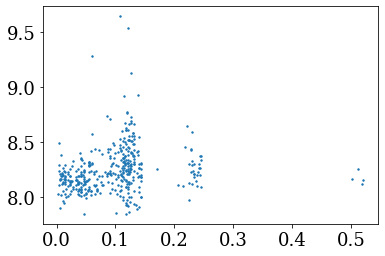

In [25]:
plt.scatter(dasch['year'].values[dbest][ecl] % 190./365.24, dasch['magcal_magdep'].values[dbest][ecl], s=2)

In [26]:
# the final array of years from the "nodal_period" notebook, used for ploting the same
years_i = [1904.94091894, 1916.97932755, 1932.93737523, 1941.41312124,
       1943.99290586, 1947.44868927, 1972.16494434, 1991.55880986,
       2001.11837748, 2003.78460537, 2005.94881192, 2008.24635954,
       2019.19398799]

In [27]:
np.nanmin(dasch['year'][dbest])

1893.331782

In [28]:
sum(dasch['year'][dbest] > 1955)

121

1893 1910 243
1910 1925 321
1925 1940 206
1940 1943 120
1943 1945 120
1945 1955 259


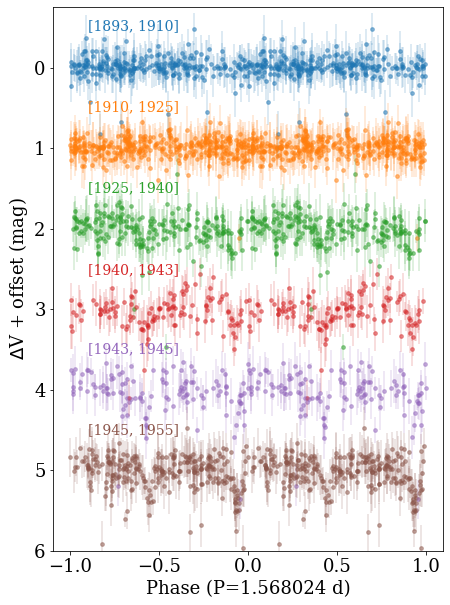

In [29]:
plt.figure(figsize=(7,10))
trange = [[1893,1910],
          [1910,1925],
          [1925,1940],
          [1940,1943],
          [1943,1945],
          [1945,1955]]

offset = 0.
doff = 1.
ksize=3

fit_dasch = np.array([0,0,0,0])
err_dasch = np.array([0,0,0,0])
time_dasch = np.array([])

for k in range(len(trange)):
    Hok = np.where((dasch['year'][dbest] >= trange[k][0]) & 
                   (dasch['year'][dbest] < trange[k][1]))[0]
    print(trange[k][0], trange[k][1], np.size(Hok))
    ss = np.argsort((dasch['Date'].values[dbest][Hok] - E0) % Per)
    
    xdata = np.hstack((((dasch['Date'].values[dbest][Hok[ss]] - E0) % Per)/Per-1, 
                       ((dasch['Date'].values[dbest][Hok][ss] - E0) % Per)/Per))
    ydata = np.hstack((dasch['magcal_magdep'].values[dbest][Hok][ss]- np.nanmedian(dasch['magcal_magdep'].values[dbest]),
                       dasch['magcal_magdep'].values[dbest][Hok][ss]- np.nanmedian(dasch['magcal_magdep'].values[dbest])))
    edata = np.hstack((dasch['magcal_local_rms'].values[dbest][Hok][ss], 
                       dasch['magcal_local_rms'].values[dbest][Hok][ss]))
    
    plt.errorbar(xdata, ydata + offset , yerr=edata, 
                 alpha=0.2, linestyle='none', marker='.', markersize=5,
                 label=str(k), color='C'+str(k))
    plt.scatter(xdata, ydata + offset, s=15, alpha=0.4)
    
    smo = convolve(ydata, Box1DKernel(ksize), boundary='extend')
#     plt.plot(xdata, smo + offset, lw=1, c='C'+str(k), alpha=0.7)

    plt.text(-0.9, np.nanmedian(smo) + offset - 0.45 , 
             str(trange[k]), color='C'+str(k), fontsize=14 )

    xr = np.where((xdata > 0.6) & (xdata < 1.3) & np.isfinite(ydata))[0]
    p0 = [0.1, np.nanmedian(ydata), 0.9, 0.05]
    bnds = [(0., -.5, 0.7, 0.015), (1.5, .5, 1.2, 0.2)]
    fit, cov = curve_fit(gaus, xdata[xr], ydata[xr], p0=p0, bounds=bnds, sigma=edata[xr], absolute_sigma=True)
    
    fit_dasch = np.vstack((fit_dasch, fit))
    err_dasch = np.vstack((err_dasch, np.sqrt(np.diag(cov))))
    time_dasch = np.append(time_dasch, np.nanmedian(dasch['Date'].values[dbest][Hok[ss]] - BJD0_tess))
#     print(np.nanmedian(dasch['year'].values[dbest][Hok]))
#     plt.plot(xdata[xr], gaus(xdata[xr], *fit) + offset, c='C'+str(k), lw=3)
    
    offset += doff
    
fit_dasch = fit_dasch[1:]
err_dasch = err_dasch[1:]
plt.gca().invert_yaxis()
plt.ylim(6, -.75)
plt.xlabel('Phase (P='+str(Per)+' d)')
plt.ylabel('$\Delta$V + offset (mag)')
# plt.savefig('dasch_lc.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25)
plt.savefig('fig2.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [30]:
# Data behind Figure (DbF) dump for AAS Journals
df_out = pd.DataFrame(data={'jd':dasch['Date'].values[dbest],
                            'year':dasch['year'][dbest],
                            'mag':dasch['magcal_magdep'].values[dbest],
                            'err':dasch['magcal_local_rms'].values[dbest]})
df_out.to_csv('fig2_data.csv',index=False)

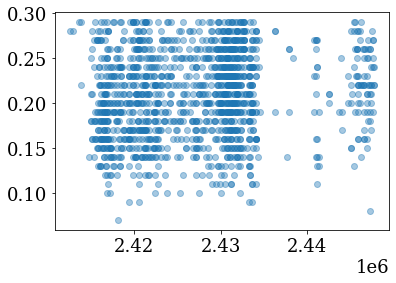

In [31]:
# data quality is fairly stable throughout
plt.scatter(dasch['Date'].values[dbest], dasch['magcal_local_rms'][dbest], alpha=0.4)

(-0.5, 0.5)

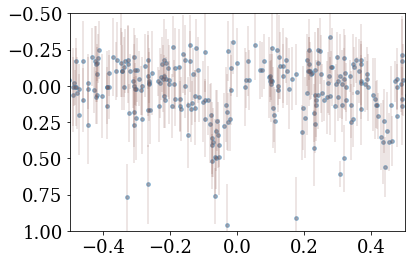

In [32]:
# the final chunk of data used
plt.errorbar(xdata, ydata , yerr=edata, 
             alpha=0.2, linestyle='none', marker='.', markersize=5,
             label=str(k), color='C'+str(k))
plt.scatter(xdata, ydata, s=15, alpha=0.4)
plt.gca().invert_yaxis()
plt.ylim(1, -0.5)
plt.xlim(-0.5, 0.5)


In [33]:
plt.close()

In [34]:
P_AC = 190.529
T_AC = 2448063.8

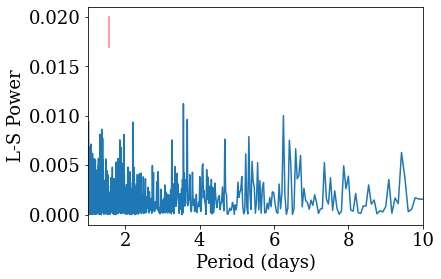

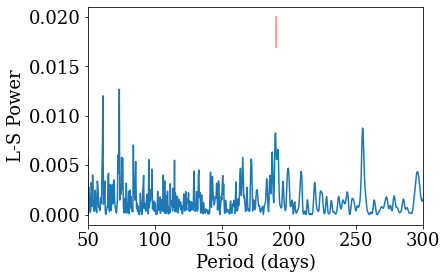

In [35]:
LS = LombScargle(dasch['Date'].values[dbest], dasch['magcal_magdep'].values[dbest])
# LS = LombScargle(xdata, ydata)

ls_F = np.linspace(1/300, 1/1, 1000)
ls_P = LS.power(ls_F)


plt.figure()
plt.plot(1./ls_F, ls_P)
plt.plot([1.568024, 1.568024], [0.02,0.017], c='r', alpha=0.5)
plt.plot([P_AC, P_AC], [0.02,0.017], c='r', alpha=0.5)
# plt.xscale('log')
plt.xlabel('Period (days)')
plt.ylabel('L-S Power')
plt.xlim(1, 10)
plt.show()

ls_F = 1/np.linspace(1, 350, 1000)
ls_P = LS.power(ls_F)

plt.figure()
plt.plot(1./ls_F, ls_P)
plt.plot([1.568024, 1.568024], [0.02,0.017], c='r', alpha=0.5)
plt.plot([190.529, 190.529], [0.02,0.017], c='r', alpha=0.5)
# plt.xscale('log')
plt.xlabel('Period (days)')
plt.ylabel('L-S Power')
plt.xlim(50,300)
plt.show()

In [44]:
# LS = LombScargle(dasch['Date'].values[dbest], dasch['magcal_magdep'].values[dbest])
# LS = LombScargle(xdata, ydata)
BLSmodel = BoxLeastSquares(dasch['Date'].values[dbest], dasch['magcal_magdep'].values[dbest] )
BLS = BLSmodel.power(1/ls_F, 0.05)
# ls_F = np.linspace(1/300, 1/1, 1000)
# ls_P = LS.power(ls_F)

BLS.keys()


dict_keys(['objective', 'period', 'power', 'depth', 'depth_err', 'duration', 'transit_time', 'depth_snr', 'log_likelihood'])

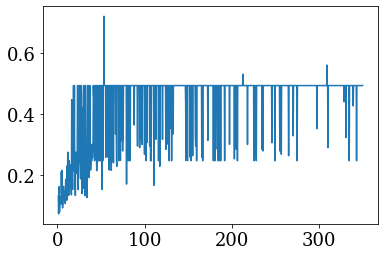

In [42]:
plt.plot(1./ls_F, BLS.power)

1893 1910 243


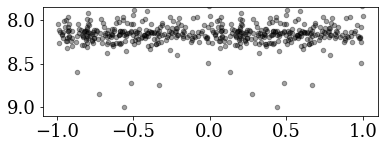

1910 1925 321


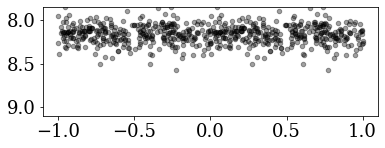

1925 1940 206


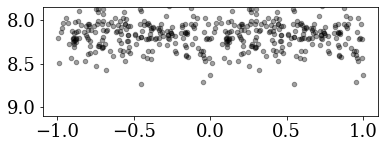

1940 1943 120


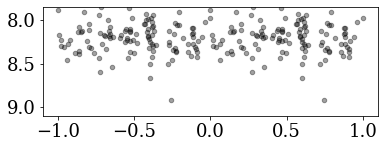

1943 1945 120


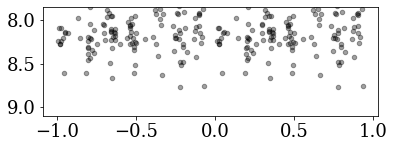

1945 1955 259


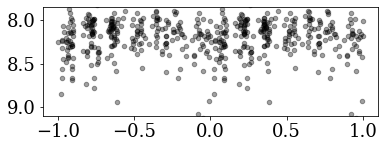

In [36]:
# plt.scatter(((dasch['Date'].values[dbest] - T_AC) % P_AC) / P_AC, 
#             dasch['magcal_magdep'].values[dbest], s=20, c='k', alpha=0.37)
# plt.scatter(((dasch['Date'].values[dbest] - T_AC) % P_AC) / P_AC-1, 
#             dasch['magcal_magdep'].values[dbest], s=20, c='k', alpha=0.37)

for k in range(len(trange)):
    Hok = np.where((dasch['year'][dbest] >= trange[k][0]) & 
                   (dasch['year'][dbest] < trange[k][1]))[0]
    print(trange[k][0], trange[k][1], np.size(Hok))
    ss = np.argsort((dasch['Date'].values[dbest][Hok] - E0) % Per)

    plt.figure(figsize=(6,2))
    plt.scatter(((dasch['Date'].values[dbest][Hok[ss]] - T_AC) % P_AC) / P_AC, 
                dasch['magcal_magdep'].values[dbest][Hok[ss]], s=20, c='k', alpha=0.37)
    plt.scatter(((dasch['Date'].values[dbest][Hok[ss]] - T_AC) % P_AC) / P_AC-1, 
                dasch['magcal_magdep'].values[dbest][Hok[ss]], s=20, c='k', alpha=0.37)
    plt.ylim(9.1, 7.85)
    plt.show()




In [37]:
# any sign of the 3rd body eclipse in the G'75 data?

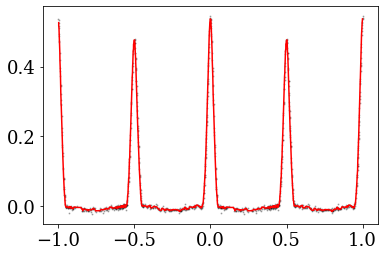

In [38]:

xdata = np.hstack((((g75['dd'] + g75['dm'] + 2440000 - E0) % Per) / Per, 
                   ((g75['dd'] + g75['dm'] + 2440000 - E0) % Per) / Per - 1))
ydata = np.hstack((ubvy - np.nanmedian(ubvy), ubvy - np.nanmedian(ubvy)))

# xr = np.where((xdata > -0.2) & (xdata < 0.2))[0]

phz1 = xdata
pfl1 = ydata

ss1 = np.argsort(phz1)
psmo1 = pd.Series(pfl1[ss1]).rolling(5, center=True).median()

ind1 = np.hstack((np.arange(len(g75['dd'])), np.arange(len(g75['dd']))))
out1 = np.where((phz1[ss1] >= -0.5) & (phz1[ss1] < 0.5))[0]
sout1 = np.argsort(ind1[ss1][out1])

plt.scatter(phz1, pfl1, s=1, alpha=0.25, c='k')
plt.plot(phz1[ss1], psmo1, c='r')
# plt.xlabel('P = '+str(period_p))
# plt.ylabel('Relative Flux')


In [39]:
# len(model1)*2

(0.85, 1.0)

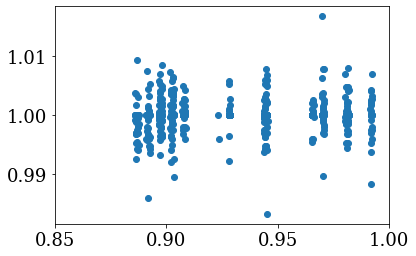

In [40]:
model1 = psmo1[out1].values[sout1] - 1

xdata = np.hstack((((g75['dd'] + g75['dm'] + 2440000 - T_AC) % P_AC) / P_AC, 
                   ((g75['dd'] + g75['dm'] + 2440000 - T_AC) % P_AC) / P_AC - 1))
ydata = np.hstack((ubvy - np.nanmedian(ubvy) - model1, ubvy - np.nanmedian(ubvy) - model1))

plt.scatter(xdata, ydata)
plt.xlim(.85,1)

## ASAS

In [41]:
asas = pd.read_table('data/asas3.txt', sep=' ')
asas.columns

Index(['Unnamed: 0', 'HJD', 'MAG_4', 'MAG_0', 'MAG_1', 'MAG_2', 'MAG_3',
       'MER_4', 'MER_0', 'MER_1', 'MER_2', 'MER_3', 'GRADE', 'FRAME'],
      dtype='object')

662


(8.3, 7.9)

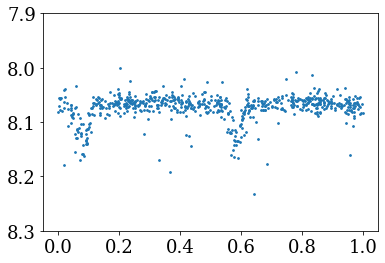

In [42]:
aok = asas['GRADE'] == 'A'
print(sum(aok))

plt.scatter(((asas['HJD'][aok] + 2450000 - E0) % Per)/Per, asas['MAG_4'][aok], s=3)
plt.ylim(8.3, 7.9)

143 253 160 106


(8.2, 8.0)

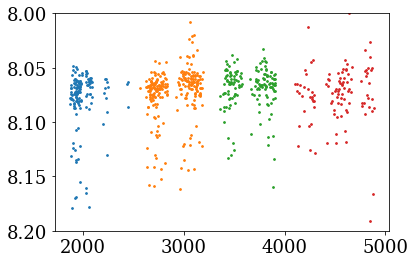

In [43]:
a1 = (asas['GRADE'] == 'A') & (asas['HJD'] < 2500)
a2 = (asas['GRADE'] == 'A') & (asas['HJD'] > 2500) & (asas['HJD'] < 3200)
a3 = (asas['GRADE'] == 'A') & (asas['HJD'] > 3200) & (asas['HJD'] < 4000)
a4 = (asas['GRADE'] == 'A') & (asas['HJD'] > 4000)

print(sum(a1), sum(a2), sum(a3), sum(a4))
plt.scatter(asas['HJD'][a1], asas['MAG_4'][a1], s=3)
plt.scatter(asas['HJD'][a2], asas['MAG_4'][a2], s=3)
plt.scatter(asas['HJD'][a3], asas['MAG_4'][a3], s=3)
plt.scatter(asas['HJD'][a4], asas['MAG_4'][a4], s=3)
plt.ylim(8.2,8)

Text(0, 0.5, 'V (mag)')

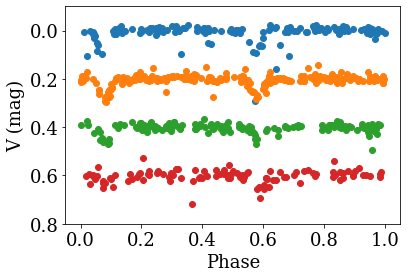

In [44]:
plt.scatter(((asas['HJD'][a1] + 2450000 - E0) % Per)/Per, asas['MAG_4'][a1] - np.nanmedian(asas['MAG_4'][a1]))
plt.scatter(((asas['HJD'][a2] + 2450000 - E0) % Per)/Per, asas['MAG_4'][a2] - np.nanmedian(asas['MAG_4'][a2])+.2)
plt.scatter(((asas['HJD'][a3] + 2450000 - E0) % Per)/Per, asas['MAG_4'][a3] - np.nanmedian(asas['MAG_4'][a3])+.4)
plt.scatter(((asas['HJD'][a4] + 2450000 - E0) % Per)/Per, asas['MAG_4'][a4] - np.nanmedian(asas['MAG_4'][a4])+.6)
plt.ylim(.8, -0.1)
plt.xlabel('Phase')
plt.ylabel('V (mag)')

[ 0.09829273 -0.00118399  0.0714049   0.01676178]
[ 0.09163757 -0.00238927  0.07904305  0.01667429]
[ 0.07551252 -0.0010749   0.08230079  0.01429774]
[ 0.03264155 -0.00708179  0.09892927  0.04287233]


Text(0, 0.5, 'V (mag)')

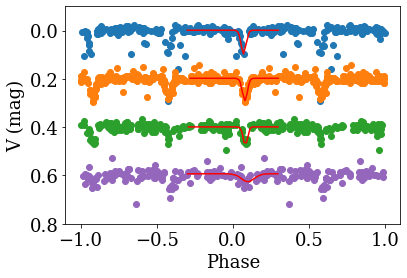

In [45]:
p0 = [0.1, 0., 0.1, 0.05]

##
xdata = np.hstack((((asas['HJD'][a1] + 2450000 - E0) % Per)/Per, 
                   ((asas['HJD'][a1] + 2450000 - E0) % Per)/Per - 1))
ydata = np.hstack((asas['MAG_4'][a1] - np.nanmedian(asas['MAG_4'][a1]), 
                   asas['MAG_4'][a1] - np.nanmedian(asas['MAG_4'][a1])))
xr = np.where((xdata > -0.3) & (xdata < 0.3))[0]
xr = xr[np.argsort(xdata[xr])]
fit, cov = curve_fit(gaus, xdata[xr], ydata[xr], p0=p0)
print(fit)
fit_a1 = fit
err_a1 = np.sqrt(np.diag(cov))

plt.scatter(xdata, ydata)
plt.plot(xdata[xr], gaus(xdata[xr], *fit), c='r')

##
xdata = np.hstack((((asas['HJD'][a2] + 2450000 - E0) % Per)/Per, 
                   ((asas['HJD'][a2] + 2450000 - E0) % Per)/Per - 1))
ydata = np.hstack((asas['MAG_4'][a2] - np.nanmedian(asas['MAG_4'][a2]), 
                   asas['MAG_4'][a2] - np.nanmedian(asas['MAG_4'][a2])))
xr = np.where((xdata > -0.3) & (xdata < 0.3))[0]
xr = xr[np.argsort(xdata[xr])]
fit, cov = curve_fit(gaus, xdata[xr], ydata[xr], p0=p0)
print(fit)
fit_a2 = fit
err_a2 = np.sqrt(np.diag(cov))


plt.scatter(xdata, ydata + 0.2)
plt.plot(xdata[xr], gaus(xdata[xr], *fit)+0.2, c='r')

##
xdata = np.hstack((((asas['HJD'][a3] + 2450000 - E0) % Per)/Per, 
                   ((asas['HJD'][a3] + 2450000 - E0) % Per)/Per - 1))
ydata = np.hstack((asas['MAG_4'][a3] - np.nanmedian(asas['MAG_4'][a3]), 
                   asas['MAG_4'][a3] - np.nanmedian(asas['MAG_4'][a3])))
xr = np.where((xdata > -0.3) & (xdata < 0.3) & (ydata < 0.2))[0]
xr = xr[np.argsort(xdata[xr])]
fit, cov = curve_fit(gaus, xdata[xr], ydata[xr], p0=p0)
print(fit)
fit_a3 = fit
err_a3 = np.sqrt(np.diag(cov))


plt.scatter(xdata, ydata + 0.4)
plt.plot(xdata[xr], gaus(xdata[xr], *fit)+0.4, c='r')

##
xdata = np.hstack((((asas['HJD'][a4] + 2450000 - E0) % Per)/Per, 
                   ((asas['HJD'][a4] + 2450000 - E0) % Per)/Per - 1))
ydata = np.hstack((asas['MAG_4'][a4] - np.nanmedian(asas['MAG_4'][a4]), 
                   asas['MAG_4'][a4] - np.nanmedian(asas['MAG_4'][a4])))
xr = np.where((xdata > -0.3) & (xdata < 0.3))[0]
xr = xr[np.argsort(xdata[xr])]
fit, cov = curve_fit(gaus, xdata[xr], ydata[xr], p0=p0)
print(fit)
fit_a4 = fit
err_a4 = np.sqrt(np.diag(cov))


plt.scatter(xdata, ydata+0.6, c='C4')
plt.plot(xdata[xr], gaus(xdata[xr], *fit)+0.6, c='r')

plt.ylim(.8, -0.1)
plt.xlabel('Phase')
plt.ylabel('V (mag)')

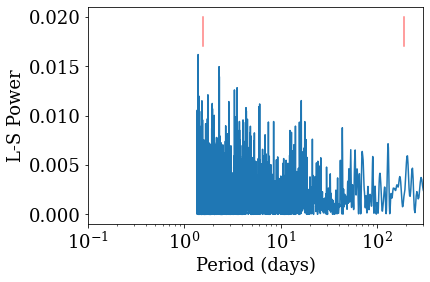

In [46]:
ls_F, ls_P = LombScargle(asas['HJD'], asas['MAG_4']).autopower()

# ls_F = np.linspace(1/300, 1/1, 1000)
# ls_P = LS.power(ls_F)


plt.figure()
plt.plot(1./ls_F, ls_P)
plt.plot([1.568024, 1.568024], [0.02,0.017], c='r', alpha=0.5)
plt.plot([190.529, 190.529], [0.02,0.017], c='r', alpha=0.5)
plt.xscale('log')
plt.xlabel('Period (days)')
plt.ylabel('L-S Power')
plt.xlim(.1, 300)
plt.show()

(8.2, 8.0)

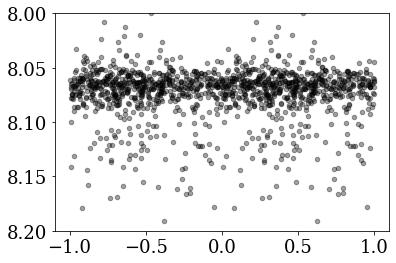

In [47]:
tmp = asas['GRADE'] == 'A'
plt.scatter(((asas['HJD'][tmp] + 2450000 - T_AC) % P_AC) / P_AC, asas['MAG_4'][tmp], s=20, c='k', alpha=0.37)
plt.scatter(((asas['HJD'][tmp] + 2450000 - T_AC) % P_AC) / P_AC -1, asas['MAG_4'][tmp], s=20, c='k', alpha=0.37)
plt.ylim(8.2, 8)

<ErrorbarContainer object of 3 artists>

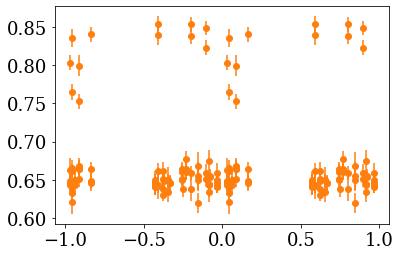

In [48]:
plt.errorbar(((hip['JD-2440000'][hok]+2440000 - T_AC) % P_AC) / P_AC, 
             hip[' Hpmag '][hok] - np.nanmedian(hip[' Hpmag '][hok]) +.65, yerr=hip['s.e. '][hok], 
             linestyle='None', marker='o', color='C1')
plt.errorbar(((hip['JD-2440000'][hok]+2440000 - T_AC) % P_AC) / P_AC-1, 
             hip[' Hpmag '][hok] - np.nanmedian(hip[' Hpmag '][hok]) +.65, yerr=hip['s.e. '][hok], 
             linestyle='None', marker='o', color='C1')

In [49]:
# # make a nice combo plot for AstroFest of all "modern" data (1970's to early 00's)
# plt.figure(figsize=(7,10))
# # plt.grid(True, zorder=1000)

# plt.scatter(((g75['dd'] + g75['dm'] + 2440000 - E0) % Per) / Per,  ubvy - np.nanmedian(ubvy), s=3, c='C0')
# plt.scatter(((g75['dd'] + g75['dm'] + 2440000 - E0) % Per) / Per - 1,  ubvy - np.nanmedian(ubvy), s=3, c='C0')

# plt.text(-0.9, -0.04, 'Gyldenkerne+ (1975)', fontsize=14, c='C0')

# plt.errorbar(((hip['JD-2440000'][hok]+2440000 - E0) % Per) / Per, 
#              hip[' Hpmag '][hok] - np.nanmedian(hip[' Hpmag '][hok]) +.65, yerr=hip['s.e. '][hok], 
#              linestyle='None', marker='o', color='C2')
# plt.errorbar(((hip['JD-2440000'][hok]+2440000 - E0) % Per) / Per - 1, 
#              hip[' Hpmag '][hok] - np.nanmedian(hip[' Hpmag '][hok]) +.65, yerr=hip['s.e. '][hok], 
#              linestyle='None', marker='o', color='C2')

# plt.text(-0.9, 0.6, 'Hipparcos (1991)', fontsize=14, c='C2')

# plt.scatter(((asas['HJD'][a1] + 2450000 - E0) % Per)/Per, asas['MAG_4'][a1] - np.nanmedian(asas['MAG_4'][a1])+1, c='C5', s=15)
# plt.scatter(((asas['HJD'][a2] + 2450000 - E0) % Per)/Per, asas['MAG_4'][a2] - np.nanmedian(asas['MAG_4'][a2])+1.2, c='C3', s=15)
# plt.scatter(((asas['HJD'][a3] + 2450000 - E0) % Per)/Per, asas['MAG_4'][a3] - np.nanmedian(asas['MAG_4'][a3])+1.4, c='C4', s=15)
# plt.scatter(((asas['HJD'][a4] + 2450000 - E0) % Per)/Per, asas['MAG_4'][a4] - np.nanmedian(asas['MAG_4'][a4])+1.6, c='C6', s=15)

# plt.scatter(((asas['HJD'][a1] + 2450000 - E0) % Per)/Per - 1, asas['MAG_4'][a1] - np.nanmedian(asas['MAG_4'][a1])+1, c='C5', s=15)
# plt.scatter(((asas['HJD'][a2] + 2450000 - E0) % Per)/Per - 1, asas['MAG_4'][a2] - np.nanmedian(asas['MAG_4'][a2])+1.2, c='C3', s=15)
# plt.scatter(((asas['HJD'][a3] + 2450000 - E0) % Per)/Per - 1, asas['MAG_4'][a3] - np.nanmedian(asas['MAG_4'][a3])+1.4, c='C4', s=15)
# plt.scatter(((asas['HJD'][a4] + 2450000 - E0) % Per)/Per - 1, asas['MAG_4'][a4] - np.nanmedian(asas['MAG_4'][a4])+1.6, c='C6', s=15)

# plt.text(-0.9, 0.95, 'ASAS (2001)', fontsize=14, c='C5')
# plt.text(-0.9, 1.15, 'ASAS (2003)', fontsize=14, c='C3')
# plt.text(-0.9, 1.35, 'ASAS (2005)', fontsize=14, c='C4')
# plt.text(-0.9, 1.55, 'ASAS (2008)', fontsize=14, c='C6')

# plt.gca().invert_yaxis()
# # plt.xlabel('Phase')
# plt.xlabel('Phase (P='+str(Per)+' d)')
# plt.ylabel('$\Delta$V + offset (mag)')
# plt.ylim(1.75, -0.1)
# # plt.savefig('modern_lc.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25)

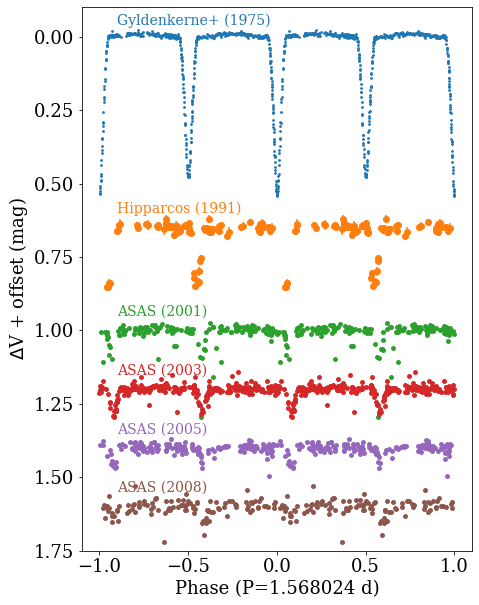

In [50]:
# make a nice combo plot 
plt.figure(figsize=(7,10))
# plt.grid(True, zorder=1000)

plt.scatter(((g75['dd'] + g75['dm'] + 2440000 - E0) % Per) / Per,  ubvy - np.nanmedian(ubvy), s=3, c='C0')
plt.scatter(((g75['dd'] + g75['dm'] + 2440000 - E0) % Per) / Per - 1,  ubvy - np.nanmedian(ubvy), s=3, c='C0')

plt.text(-0.9, -0.04, 'Gyldenkerne+ (1975)', fontsize=14, c='C0')

plt.errorbar(((hip['JD-2440000'][hok]+2440000 - E0) % Per) / Per, 
             hip[' Hpmag '][hok] - np.nanmedian(hip[' Hpmag '][hok]) +.65, yerr=hip['s.e. '][hok], 
             linestyle='None', marker='o', color='C1')
plt.errorbar(((hip['JD-2440000'][hok]+2440000 - E0) % Per) / Per - 1, 
             hip[' Hpmag '][hok] - np.nanmedian(hip[' Hpmag '][hok]) +.65, yerr=hip['s.e. '][hok], 
             linestyle='None', marker='o', color='C1')

plt.text(-0.9, 0.6, 'Hipparcos (1991)', fontsize=14, c='C1')

plt.scatter(((asas['HJD'][a1] + 2450000 - E0) % Per)/Per, asas['MAG_4'][a1] - np.nanmedian(asas['MAG_4'][a1])+1, c='C2', s=15)
plt.scatter(((asas['HJD'][a2] + 2450000 - E0) % Per)/Per, asas['MAG_4'][a2] - np.nanmedian(asas['MAG_4'][a2])+1.2, c='C3', s=15)
plt.scatter(((asas['HJD'][a3] + 2450000 - E0) % Per)/Per, asas['MAG_4'][a3] - np.nanmedian(asas['MAG_4'][a3])+1.4, c='C4', s=15)
plt.scatter(((asas['HJD'][a4] + 2450000 - E0) % Per)/Per, asas['MAG_4'][a4] - np.nanmedian(asas['MAG_4'][a4])+1.6, c='C5', s=15)

plt.scatter(((asas['HJD'][a1] + 2450000 - E0) % Per)/Per - 1, asas['MAG_4'][a1] - np.nanmedian(asas['MAG_4'][a1])+1, c='C2', s=15)
plt.scatter(((asas['HJD'][a2] + 2450000 - E0) % Per)/Per - 1, asas['MAG_4'][a2] - np.nanmedian(asas['MAG_4'][a2])+1.2, c='C3', s=15)
plt.scatter(((asas['HJD'][a3] + 2450000 - E0) % Per)/Per - 1, asas['MAG_4'][a3] - np.nanmedian(asas['MAG_4'][a3])+1.4, c='C4', s=15)
plt.scatter(((asas['HJD'][a4] + 2450000 - E0) % Per)/Per - 1, asas['MAG_4'][a4] - np.nanmedian(asas['MAG_4'][a4])+1.6, c='C5', s=15)

plt.text(-0.9, 0.95, 'ASAS (2001)', fontsize=14, c='C2')
plt.text(-0.9, 1.15, 'ASAS (2003)', fontsize=14, c='C3')
plt.text(-0.9, 1.35, 'ASAS (2005)', fontsize=14, c='C4')
plt.text(-0.9, 1.55, 'ASAS (2008)', fontsize=14, c='C5')

plt.gca().invert_yaxis()
# plt.xlabel('Phase')
plt.xlabel('Phase (P='+str(Per)+' d)')
plt.ylabel('$\Delta$V + offset (mag)')
plt.ylim(1.75, -0.1)
# plt.savefig('modern_lc.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25)
plt.savefig('fig1.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25)

## TESS
The FUTURE... and also the final eclipses for this system.

In [36]:
tess_tbl = Table.read('data/tess2019058134432-s0009-0000000434479378-0139-s_lc.fits', format='fits')
df = tess_tbl.to_pandas()

(0.007, -0.006)

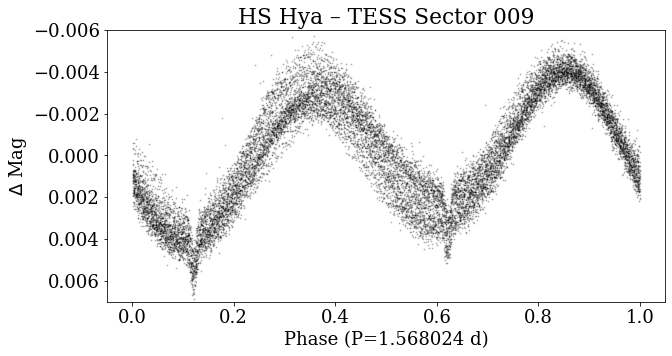

In [37]:
Tmag = -2.5*np.log10(df['PDCSAP_FLUX'])

plt.figure(figsize=(10,5))
plt.scatter(((df['TIME']+BJD0_tess-E0) % Per)/Per, Tmag - np.nanmedian(Tmag), s=1, alpha=0.2, c='k')
# plt.scatter(((df['TIME']+BJD0_tess-E0) % Per)/Per - 1, Tmag - np.nanmedian(Tmag), s=1, alpha=0.2, c='k')

plt.gca().invert_yaxis()
plt.xlabel('Phase (P='+str(Per)+' d)')
plt.ylabel('$\Delta$ Mag')
plt.title('HS Hya – TESS Sector 009')
plt.ylim(0.007, -0.006)

# plt.savefig('TESS_LC.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [38]:
print(df['TIME'].max() - df['TIME'].min())

25.25811254897735


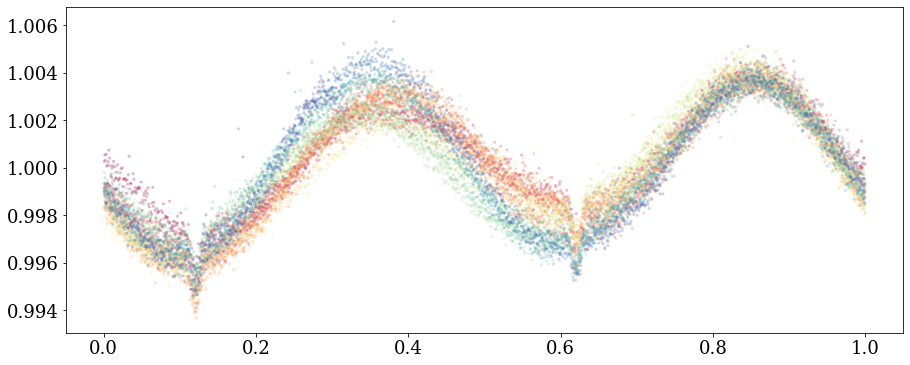

In [39]:
plt.figure(figsize=(15,6))

plt.scatter(((df['TIME']+BJD0_tess-E0) % Per)/Per, df['PDCSAP_FLUX'] / np.nanmedian(df['PDCSAP_FLUX']), 
            s=5, alpha=0.2, c=df['TIME'], cmap=plt.cm.Spectral)



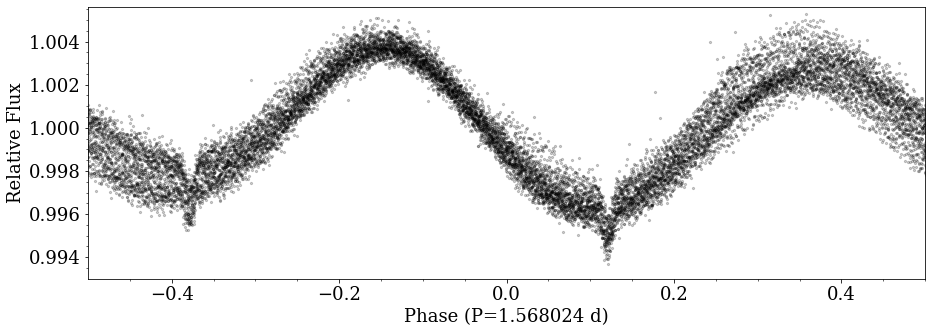

In [40]:
# Tmag = -2.5*np.log10(df['PDCSAP_FLUX'])

plt.figure(figsize=(15,5))
plt.scatter(((df['TIME']+BJD0_tess-E0) % Per)/Per, df['PDCSAP_FLUX'] / np.nanmedian(df['PDCSAP_FLUX']), 
            s=5, alpha=0.2, c='k')
plt.scatter(((df['TIME']+BJD0_tess-E0) % Per)/Per - 1, df['PDCSAP_FLUX'] / np.nanmedian(df['PDCSAP_FLUX']), 
            s=5, alpha=0.2, c='k')

# plt.gca().invert_yaxis()
plt.xlabel('Phase (P='+str(Per)+' d)')
plt.ylabel('Relative Flux')

plt.ylim(.993,1.0056)
plt.xlim(-.5,.5)
plt.minorticks_on()
# plt.savefig('tess_lc.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25)
plt.savefig('fig3.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [41]:
print(np.nanmean(df['PDCSAP_FLUX_ERR'] / np.nanmedian(df['PDCSAP_FLUX'])))

0.00029805637


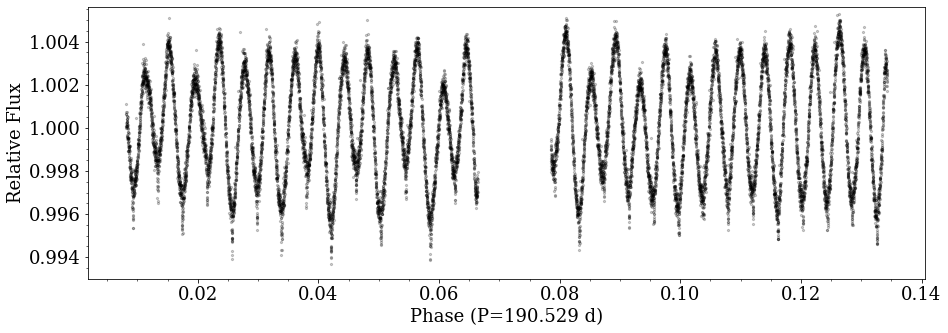

In [42]:
# where is the 3rd body in the orbit during TESS?

plt.figure(figsize=(15,5))
plt.scatter( ((df['TIME']+BJD0_tess - T_AC) % P_AC)/P_AC, df['PDCSAP_FLUX'] / np.nanmedian(df['PDCSAP_FLUX']), 
            s=5, alpha=0.2, c='k')

plt.xlabel('Phase (P='+str(P_AC)+' d)')
plt.ylabel('Relative Flux')

plt.ylim(.993,1.0056)
# plt.xlim(-.5,.5)
plt.minorticks_on()
# plt.savefig('tess_lc.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [43]:
max(((df['TIME']+BJD0_tess - T_AC) % P_AC)/P_AC) - min(((df['TIME']+BJD0_tess - T_AC) % P_AC)/P_AC)

0.132568336310223

In [45]:
print(min(((df['TIME']+BJD0_tess - T_AC) % P_AC)/P_AC), min(((df['TIME']+BJD0_tess - T_AC) % P_AC)))

0.0017140190863331193 0.32657034249996286


[0.00166435 0.00379738 0.12033675 0.00546378]
[7.42542052e-05 4.99905499e-05 2.47016043e-04 3.37248619e-04]


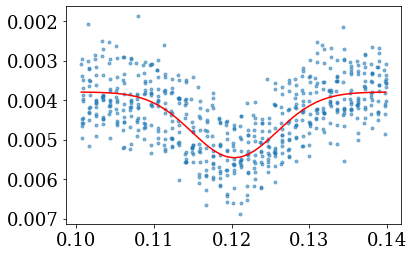

In [59]:
# fitting the eclipse

p0 = [0.002, 0.003, 0.12, 0.005]

##
xdata = ((df['TIME']+BJD0_tess-E0) % Per)/Per
ydata = Tmag - np.nanmedian(Tmag)

xr = np.where((xdata > 0.1) & (xdata < 0.14) & np.isfinite(ydata))[0]
xr = xr[np.argsort(xdata[xr])]
xr_e = xr
fit, cov = curve_fit(gaus, xdata[xr], ydata[xr], p0=p0)
print(fit)
fit_tess = fit
err_tess = np.sqrt(np.diag(cov))
print(err_tess)

plt.scatter(xdata[xr], ydata[xr],s=9, alpha=0.53)
plt.plot(xdata[xr], gaus(xdata[xr], *fit_tess), c='r')
# plt.plot(xdata[xr], gaus(xdata[xr], *p0), c='r')

# plt.scatter((df['TIME']+BJD0_tess-E0) % Per, Tmag - np.nanmedian(Tmag)-0.004)
plt.gca().invert_yaxis()
# plt.xlim(0.1,0.15)
# plt.ylim(0.003,-0.003)

[ 0.01039137 -0.00648324  0.1089606   0.13677871]
[0.00021863 0.00023111 0.00025176 0.00237403]
-0.011376145549916616 -87.9032353807507
0.00035270728238413697


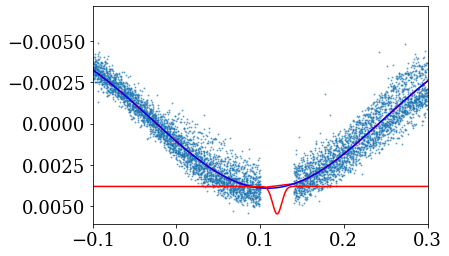

In [60]:
# fitting the phase min of the primary ellipsoidal variation

p0 = [0.002, 0.003, 0.12, 0.005]

##
xdata = np.hstack((((df['TIME']+BJD0_tess-E0) % Per)/Per, 
                   ((df['TIME']+BJD0_tess-E0) % Per)/Per-1))
ydata = np.hstack((Tmag - np.nanmedian(Tmag), 
                   Tmag - np.nanmedian(Tmag)))

xr = np.where((((xdata > -0.1) & (xdata < 0.1)) | 
               ((xdata > 0.14) & (xdata < 0.3))) & 
              np.isfinite(ydata))[0]
xr = xr[np.argsort(xdata[xr])]
fit, cov = curve_fit(gaus, xdata[xr], ydata[xr], p0=p0)
print(fit)
print(np.sqrt(np.diag(cov)))


plt.scatter(xdata[xr], ydata[xr],s=1, alpha=0.53)
plt.plot(xdata[xr], gaus(xdata[xr], *fit), c='r')
plt.plot(np.arange(-1,1,0.001), gaus(np.arange(-1,1,0.001), *fit), c='b')
# plt.plot(xdata[xr], gaus(xdata[xr], *fit_tess), c='r')
plt.plot(np.arange(-1,1,0.001), gaus(np.arange(-1,1,0.001), *fit_tess), c='r')

plt.gca().invert_yaxis()
plt.xlim(-.1,.3)

print(fit[2] - fit_tess[2], 1./ (fit[2] - fit_tess[2]))
print(np.sqrt(np.diag(cov)[2] + err_tess[2]**2))

## Putting it all together

In [61]:
times = [np.nanmedian(g75['dd'] + g75['dm'] + 2440000 - BJD0_tess), 
         np.nanmedian(hip['JD-2440000'][hok]+2440000 - BJD0_tess),
         np.nanmedian(asas['HJD'][a1] + 2450000 - BJD0_tess),
         np.nanmedian(asas['HJD'][a2] + 2450000 - BJD0_tess),
         np.nanmedian(asas['HJD'][a3] + 2450000 - BJD0_tess),
         np.nanmedian(asas['HJD'][a4] + 2450000 - BJD0_tess),
         np.nanmedian(df['TIME'])
        ]
times = np.array(times)
times = np.append(times, time_dasch) # add DASCH, ditch the first & last time-bin, since not detected

big_data = np.vstack([fit_g75, fit_hip, fit_a1, fit_a2, fit_a3, fit_a4, fit_tess, fit_dasch])
big_errs = np.vstack([err_g75, err_hip, err_a1, err_a2, err_a3, err_a4, err_tess, err_dasch])

[ 6.46152308e-01 -1.83408074e-02  1.95939941e+03  2.26813675e+01]


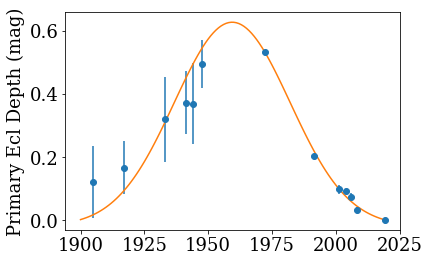

In [62]:
ysrt = np.argsort(times)

plt.errorbar(years_i, big_data[ysrt,0], yerr=big_errs[ysrt,0], marker='o', linestyle='None')
dfit,_ = curve_fit(gaus,years_i, big_data[ysrt,0], p0=[0.6, 0., 1960,25], sigma=big_errs[ysrt,0])


plt.plot(np.arange(1900,2020,1), gaus(np.arange(1900,2020,1), *dfit))
plt.ylabel('Primary Ecl Depth (mag)')

print(dfit)

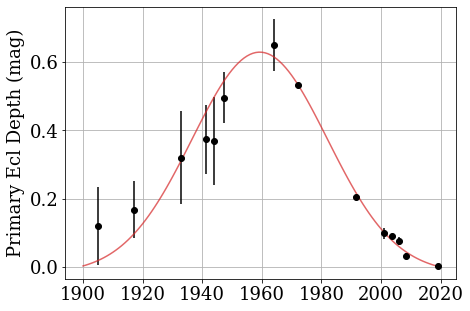

In [63]:
plt.figure(figsize=(7,5))
# xt = (times+BJD0_tess - 2455197.50000)/365.24 + 2010
xt = years_i
yt = big_data[ysrt,0]
et = big_errs[ysrt,0]

# add approx datapoint from Strohmeier+1965
xt = np.append(xt, 1964) 
yt = np.append(yt, 0.65)
et = np.append(et, 0.075)

dfit,_ = curve_fit(gaus,xt, yt, p0=[0.7, 0., 1959, 25], sigma=et)

plt.errorbar(xt, yt, yerr=et, marker='o', linestyle='None', c='k')

plt.plot(np.arange(1900,2020,1), gaus(np.arange(1900,2020,1), *dfit), c='C3', alpha=0.7)

plt.ylabel('Primary Ecl Depth (mag)')
# plt.title('HS Hya')
plt.grid(True)
# plt.savefig('historic_depth.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25)
plt.savefig('fig4.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [64]:
# Data behind Figure (DbF) dump for AAS Journals
# we want to save the JD, years, depth (mag), err

jd_tmp = times[ysrt] + BJD0_tess
jd_tmp = np.append(jd_tmp, np.nan)

df_out = pd.DataFrame(data={'jd':jd_tmp,
                            'year':xt,
                            'depth':yt,
                            'depth_err':et
                           })
df_out.to_csv('fig4_data.csv',index=False)

In [46]:
# from astropy.modeling.models import Lorentz1D

# def Lmodel(x, a, x0, fwhm):
#     s1 = Lorentz1D(amplitude = a, x_0 = x0, fwhm = fwhm)
#     return s1(x)


# plt.figure(figsize=(7,5))

# # Lfit,_ = curve_fit(Lmodel, xt, yt, p0=[0.7, 1959, 45], sigma=et, maxfev=10000)

# plt.errorbar(xt, yt, yerr=et, marker='o', linestyle='None', c='k')

# plt.plot(np.arange(1900,2021,1), gaus(np.arange(1900,2021,1), *dfit), c='C3', alpha=0.7)

# plt.plot(np.arange(1900,2021,1), Lmodel(np.arange(1900,2021,1), *[0.7, 1959, 35]), c='C0', alpha=0.7)

# plt.ylabel('Primary Ecl Depth (mag)')
# plt.ylim(0,0.7)
# plt.grid(True)

# #### nope